In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import random
import numpy as np
import tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import h5py

from stellargraph import datasets
from IPython.display import display, HTML
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UnsupervisedSampler
from stellargraph.layer.graphsage import MeanAggregator, MeanPoolingAggregator, MaxPoolingAggregator, AttentionalAggregator
from stellargraph.layer.link_inference import LinkEmbedding
from tensorflow import keras

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [5]:
nodes = list(G.nodes())
number_of_walks = 1
length = 5
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [6]:
batch_size = 50
epochs = 4
num_samples = [10, 5]
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)
# |train_gen| = |nodes|*number_of_walks*(length-1)*2/batch_size, batch_size is even

In [7]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, 
    generator=generator, 
    aggregator=MeanAggregator, 
    bias=True, 
    dropout=0.0, 
    normalize='l2', 
    activations=['relu', 'linear']
)

In [8]:
x_inp, x_out = graphsage.in_out_tensors()

In [9]:
prediction = link_classification(
    output_dim=1, output_act='sigmoid', edge_embedding_method='ip'
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [10]:
model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 1433)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50, 1433)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 10, 1433)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 50, 1433)]   0                                            
______________________________________________________________________________________________

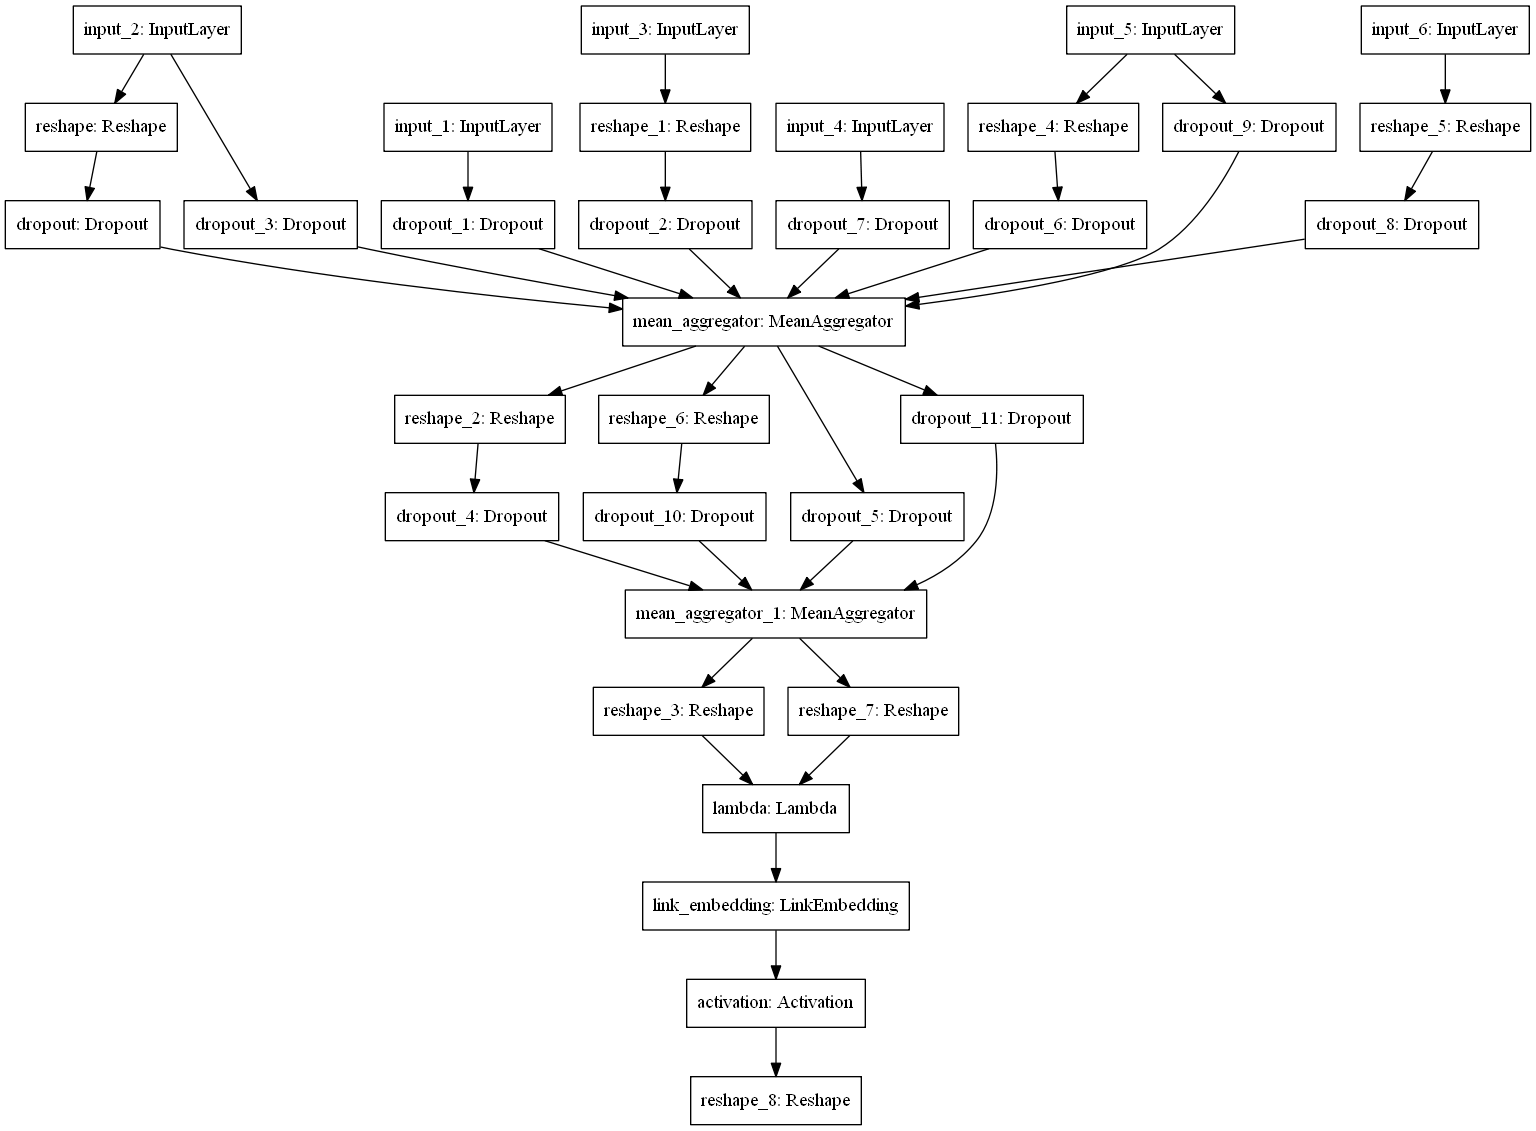

In [12]:
keras.utils.plot_model(model, show_shapes=False)

In [13]:
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

In [14]:
log_dir = os.path.join(os.getcwd(), 'logs')
os.makedirs(log_dir, exist_ok=True)
csv_logger = keras.callbacks.CSVLogger(os.path.join(log_dir, time.strftime('%Y%m%d-%H%M%S.csv')))

In [15]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
    callbacks=[es_callback, csv_logger]
)

  ...
    to  
  ['...']
Train for 434 steps
Epoch 1/4
434/434 [==============================] - 33s 75ms/step - loss: 0.5636 - binary_accuracy: 0.7442
Epoch 2/4
434/434 [==============================] - 31s 72ms/step - loss: 0.5286 - binary_accuracy: 0.7981
Epoch 3/4
434/434 [==============================] - 29s 66ms/step - loss: 0.5208 - binary_accuracy: 0.8102
Epoch 4/4
434/434 [==============================] - 32s 74ms/step - loss: 0.5147 - binary_accuracy: 0.8219


In [16]:
model_dir = os.path.join(os.getcwd(), 'models')
os.makedirs(model_dir, exist_ok=True)
model_name = os.path.join(model_dir, 'demo.h5')
model.save(model_name)

In [17]:
model_dir = os.path.join(os.getcwd(), 'models')
model_name = os.path.join(model_dir, 'demo.h5')
custom_objects = {
    'MeanAggregator': MeanAggregator, 
    'LinkEmbedding': LinkEmbedding
}
model = keras.models.load_model(model_name, custom_objects=custom_objects)
file_ = h5py.File(model_name, mode='r')
# print(file_.attrs.get('model_config'))
# print(file_.attrs.get('training_config'))
file_.close()

In [18]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
model_name = os.path.join(model_dir, 'demo-embedding.h5')
embedding_model.save(model_name)

In [19]:
model_dir = os.path.join(os.getcwd(), 'models')
model_name = os.path.join(model_dir, 'demo-embedding.h5')
custom_objects = {
    'MeanAggregator': MeanAggregator
}
embedding_model = keras.models.load_model(model_name, custom_objects=custom_objects)

In [20]:
node_ids = node_subjects.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [21]:
node_embeddings = embedding_model.predict(node_gen, verbose=1)

55/55 [==============================] - 2s 33ms/step


In [22]:
result_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(result_dir, exist_ok=True)
embedding_name = os.path.join(result_dir, 'demo-embedding.npy')
np.save(embedding_name, node_embeddings)

In [23]:
result_dir = os.path.join(os.getcwd(), 'results')
embedding_name = os.path.join(result_dir, 'demo-embedding.npy')
node_embeddings = np.load(embedding_name)

In [24]:
node_subject = node_subjects.astype('category').cat.codes
X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA
    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed['label'] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed['label'] = node_subject

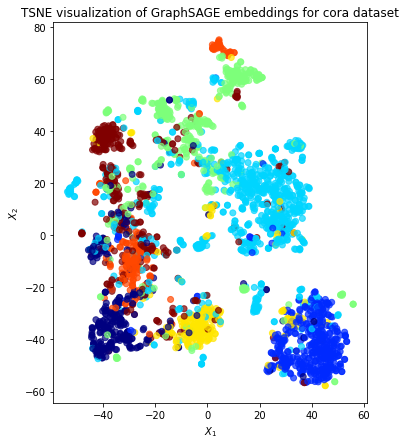

In [25]:
alpha = 0.7
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed['label'].astype('category'),
    cmap='jet',
    alpha=alpha,
)
ax.set(aspect='equal', xlabel='$X_1$', ylabel='$X_2$')
plt.title(
    '{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__)
)
plt.show()

In [26]:
X = node_embeddings
y = np.array(node_subject)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.05, stratify=y
)

In [28]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7143412359113875